In [1]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get dataset
reviews = pd.read_csv("../data/gojek_reviews.csv")
reviews.head()

,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,Forgot my airport in his car and I didn't rece...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,So far so good,0,2025-02-23 14:04:35,NaN,NaN,5.10.1,5.10.1
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,NaN,NaN,5.11.1,5.11.1
3,451872f2-472a-4696-a6f9-cb5ed515c6b6,arfandi amiruddin,5,Good,0,2025-02-23 12:46:18,NaN,NaN,5.11.1,5.11.1
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,"The ""play later"" Promo is annoying. Can't use ...",1,2025-02-23 12:32:42,NaN,NaN,4.32.1,4.32.1


# 1. Explore the dataset

### a. Analyze the distribution of review lengths

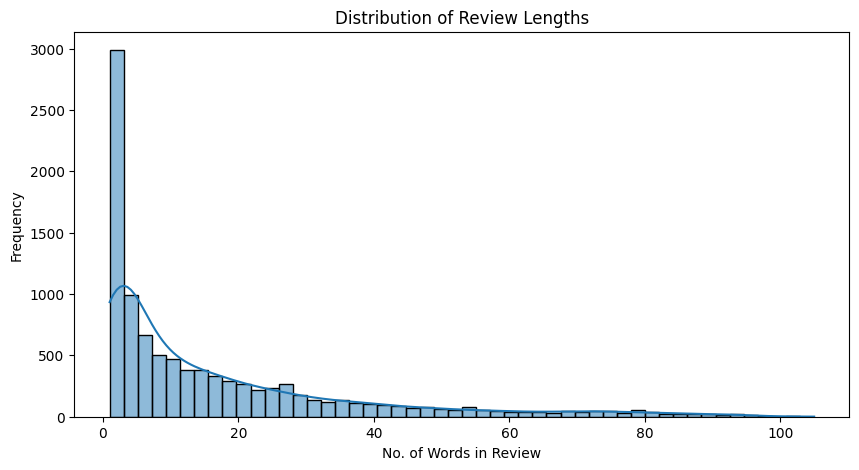

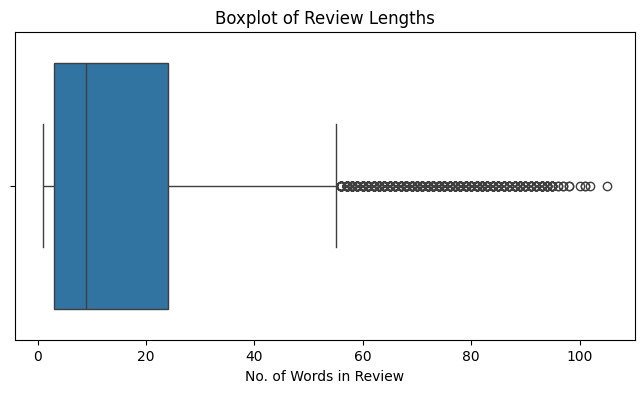

In [2]:
# Add a column for word count
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))

# Histogram to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.xlabel("No. of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=reviews['word_count'])
plt.xlabel("No. of Words in Review")
plt.title("Boxplot of Review Lengths")
plt.show()

The histogram shows a strong right-skewed distribution, meaning most reviews are very short, but the boxplot tells us that there are also many outliers (long reviews).

### b. Identify common words and phrases used in reviews

C:\Users\fireb\AppData\Local\Temp\ipykernel_17104\593663789.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


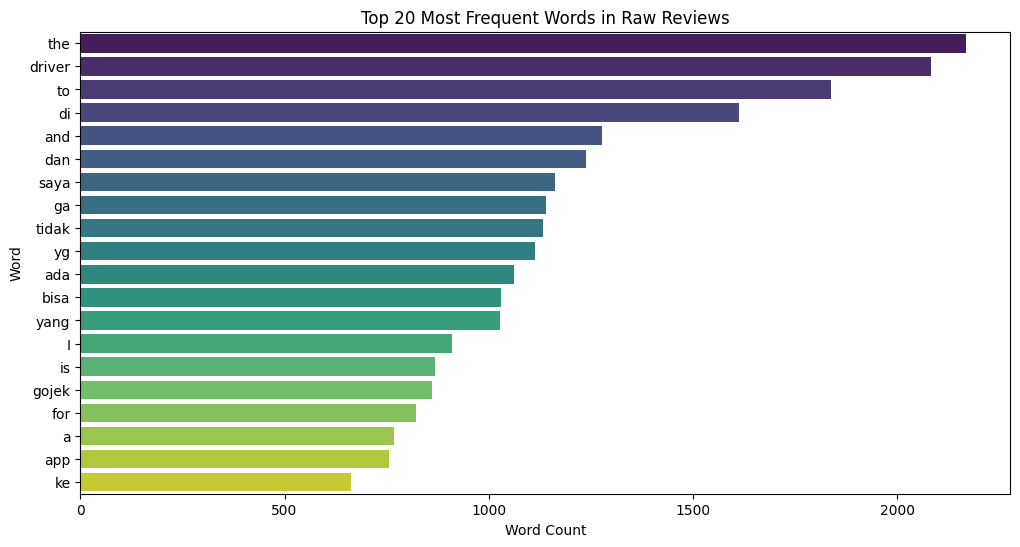

In [3]:
from collections import Counter

# Join all reviews into one string
all_words = ' '.join(reviews['content'].astype(str)).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20
most_common_words = word_freq.most_common(20)

# Seperate the words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Raw Reviews")
plt.show()

### c. Visualize word frequency distributions

In [4]:
from wordcloud import WordCloud

# Creates word cloud based on word frequency
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words")
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

# 2. Clean and preprocess text data

### a. Convert text to lowercase

In [ ]:
# Convert review content to lowercase
reviews['content'] = reviews['content'].str.lower()

### b. Remove stop words, punctuation, and special characters

In [ ]:
# Remove punctuation and special characters
import re
reviews['content'] = reviews['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else x)

# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english')) 

# Load Indonesian stopwords
id_stopwords_path = "../data/id_stopwords.txt"
id_stopwords = set()

with open(id_stopwords_path, 'r') as file:
    for line in file:
        id_stopwords.add(line.strip())

# Combine English & Indonesian stopwords
all_stopwords = english_stopwords.union(id_stopwords)

def remove_stopwords(text):
    if isinstance(text,str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stopwords]
        return ' '.join(filtered_words)
    return text

reviews['content'] = reviews['content'].apply(remove_stopwords)
reviews.dropna(subset=['content'], inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### c. Tokenization and stemming/lemmatization

In [ ]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

reviews['lemmatized_content'] = reviews['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### d. Handle duplicate or noisy data

In [ ]:
# Handle duplicate and noisy data
print(f"Original dataset shape: {reviews.shape}")

# Check and remove duplicates
duplicate_count = reviews.duplicated(subset=['content']).sum()
print(f"Found {duplicate_count} duplicate reviews")
reviews = reviews.drop_duplicates(subset=['content'])

# Remove very short reviews (likely noise)
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))
short_reviews = reviews[reviews['word_count'] < 2].shape[0]
print(f"Removing {short_reviews} very short reviews (less than 2 words)")
reviews = reviews[reviews['word_count'] >= 2]

# Handle missing values in any other columns
missing_values = reviews.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Fill missing numerical values with median (if any)
numerical_cols = reviews.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].median())

# Fill missing categorical/text values with mode (if any)
categorical_cols = reviews.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'content' and col != 'lemmatized_content' and reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].mode()[0])

# Check for outliers in rating (if present)
if 'rating' in reviews.columns:
    print("\nRating distribution:")
    print(reviews['rating'].value_counts())
    
    # Check if there are invalid ratings outside expected range (e.g., 1-5)
    invalid_ratings = reviews[(reviews['rating'] < 1) | (reviews['rating'] > 5)].shape[0]
    if invalid_ratings > 0:
        print(f"Found {invalid_ratings} reviews with invalid ratings")
        # Remove or fix invalid ratings
        reviews = reviews[(reviews['rating'] >= 1) & (reviews['rating'] <= 5)]

print(f"\nCleaned dataset shape: {reviews.shape}")
reviews.head()

Original dataset shape: (10000, 12)
Found 1816 duplicate reviews
Removing 413 very short reviews (less than 2 words)

Missing values in each column:
reviewId                   0
userName                   2
score                      0
content                    0
thumbsUpCount              0
at                         0
replyContent            3111
repliedAt               3111
reviewCreatedVersion    1184
appVersion              1184
word_count                 0
lemmatized_content         0
dtype: int64

Cleaned dataset shape: (7771, 12)


,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion,word_count,lemmatized_content
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,forgot airport car didnt receive infofollow dr...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1,9,forgot airport car didnt receive infofollow dr...
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,far good,0,2025-02-23 14:04:35,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.10.1,5.10.1,2,far good
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.11.1,5.11.1,3,drivernya cakep hehe
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,play later promo annoying cant use anw u keep ...,1,2025-02-23 12:32:42,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,4.32.1,4.32.1,11,play later promo annoying cant use anw u keep ...
5,ac4fed4e-7bf4-4677-b973-98f4d3c9df0f,Husen Badrutamam,1,jelek banget kelakuan drivernya ambil orderan ...,0,2025-02-23 10:36:21,"Hai Kak Husen, mohon maaf atas ketidaknyamanan...",2025-02-23 11:01:14,5.10.1,5.10.1,16,jelek banget kelakuan drivernya ambil orderan ...


# 3. Topic Modelling

### a. Use algorithms to identify key topics

#### Using Latent Dirichlet Allocation (LDA)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Convert each review into a list of words
reviews_tokenized = reviews['lemmatized_content'].astype(str).apply(word_tokenize)

# Assign unique ID to each word
id2word = corpora.Dictionary(reviews_tokenized)

# Convert words to Bag-of-Words format
corpus = [id2word.doc2bow(text) for text in reviews_tokenized]

# No. of topics we want to check
num_topics = 5  

# Train the model
trained_lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=num_topics, 
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print top words of each topic
trained_lda_model.print_topics()


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[(0,
  '0.011*"ok" + 0.009*"mantap" + 0.008*"pin" + 0.008*"meow" + 0.006*"customer" + 0.004*"gojek" + 0.004*"sigma" + 0.004*"easier" + 0.004*"go" + 0.003*"server"'),
 (1,
  '0.034*"driver" + 0.023*"app" + 0.013*"gojek" + 0.012*"time" + 0.011*"good" + 0.011*"order" + 0.011*"service" + 0.008*"get" + 0.007*"use" + 0.007*"even"'),
 (2,
  '0.044*"driver" + 0.017*"gojek" + 0.014*"banget" + 0.011*"drivernya" + 0.010*"aplikasi" + 0.010*"gocar" + 0.010*"cancel" + 0.009*"susah" + 0.009*"dapet" + 0.009*"gofood"'),
 (3,
  '0.033*"driver" + 0.016*"cancel" + 0.013*"aplikasi" + 0.012*"c" + 0.012*"order" + 0.010*"chat" + 0.010*"pesanan" + 0.010*"gofood" + 0.010*"customer" + 0.010*"gojek"'),
 (4,
  '0.024*"gojek" + 0.019*"gopay" + 0.019*"aplikasi" + 0.011*"promo" + 0.010*"bayar" + 0.008*"pakai" + 0.007*"plus" + 0.007*"pake" + 0.007*"mahal" + 0.006*"beli"')]

### Using Non-Negative Matrix Factorization (NMF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

documents = reviews_tokenized.apply(lambda x: ' '.join(x)).tolist()

# Transform text to TF-IDF representation
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(documents)

# Get feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Train the model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_W = nmf_model.fit_transform(tfidf) 
nmf_H = nmf_model.components_  

# Print top words of each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"{topic_idx+1}:")
    print(" + ".join([tfidf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))


1:
driver + cancel + order + susah + dapet + gocar + nunggu + jam + banget + gofood
2:
good + service + application + far + apps + job + fast + thanks + great + easy
3:
aplikasi + membantu + bagus + banget + sampah + terima + pakai + makanan + update + gopay
4:
app + great + use + easy + best + helpful + nice + time + bad + love
5:
gojek + promo + pake + plus + mahal + gofood + ya + pakai + gopay + drivernya


#### Using BERTopics

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Train the model
bertopic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)
topics, probs = bertopic_model.fit_transform(documents)
bertopic_model.reduce_topics(documents, nr_topics=num_topics)   # Reduce to no. of topics we want 

# Print top words of each topic
for topic_num in range(4):  
    topic = bertopic_model.get_topic(topic_num)
    print(f"{topic_num+1}:")
    print(" + ".join([word for word, _ in topic]))


2025-03-28 16:09:17,230 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/243 [00:00<?, ?it/s]

2025-03-28 16:09:38,383 - BERTopic - Embedding - Completed ✓
2025-03-28 16:09:38,384 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-28 16:09:41,153 - BERTopic - Dimensionality - Completed ✓
2025-03-28 16:09:41,155 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-28 16:09:42,894 - BERTopic - Cluster - Completed ✓
2025-03-28 16:09:42,897 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-28 16:09:42,977 - BERTopic - Representation - Completed ✓
2025-03-28 16:09:43,065 - BERTopic - Topic reduction - Reducing number of topics
2025-03-28 16:09:43,115 - BERTopic - Topic reduction - Reduced number of topics from 106 to 5


1:
gojek + promo + service + gopay + good + customer + banget + gofood + mahal + driver
2:
driver + gojek + map + drivernya + rating + cancel + app + gocar + titik + time
3:
app + order + aplikasi + cancel + driver + apps + chat + food + cant + login
4:
dark + mode + gelap + darkmode + theme + add + gojek + mata + terang + app


### b. Determine the optimal number of topics using coherence scores or topic coherence visualization

#### 1) By Coherence Visualization

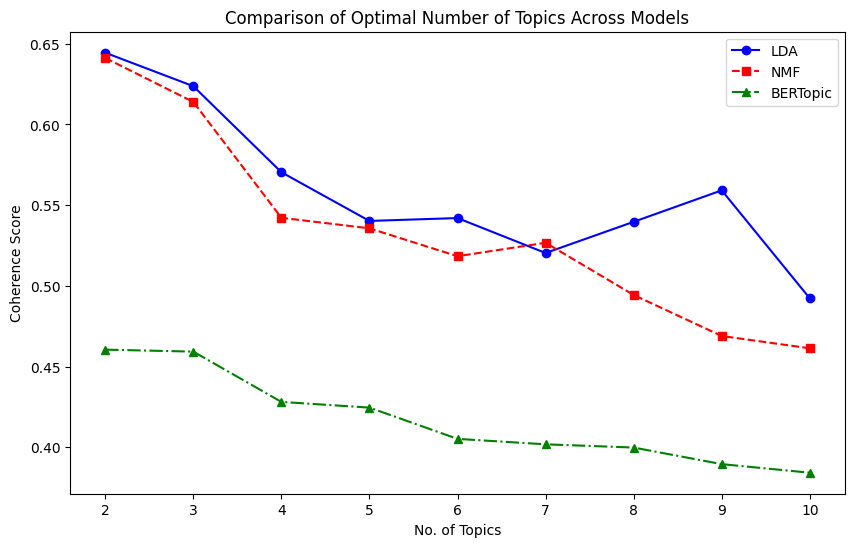

In [ ]:
from gensim.models import CoherenceModel, LdaModel
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

texts = reviews_tokenized.tolist()
topic_range = range(2, 11)      # Tests 2 to 10 topics


# LDA Coherence Scores
coherence_scores_lda = []
for num_topics in topic_range:
    # Generate LDA model for each no. of topics
    lda_model = LdaModel(       
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha="auto",
        per_word_topics=True,
    )

    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=reviews_tokenized.tolist(), dictionary=id2word, coherence="c_v"
    )
    coherence_scores_lda.append(coherence_model_lda.get_coherence())


# NMF Coherence Scores
coherence_scores_nmf = []
for num_topics in topic_range:
    # Generate NMF model for each no. of topics
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_W = nmf_model.fit_transform(tfidf)

    nmf_topics = [[tfidf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf_model.components_]

    coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_scores_nmf.append(coherence_model_nmf.get_coherence())


# BERTopic Coherence Scores
bertopic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=False)
topics, _ = bertopic_model.fit_transform(documents)
coherence_scores_bertopic = []
for num_topics in topic_range:
    # Generate LDA model for each no. of topics
    bertopic_topics = [bertopic_model.get_topic(i) for i in range(num_topics) if bertopic_model.get_topic(i)]
    bertopic_topics = [[word for word, _ in topic] for topic in bertopic_topics]

    coherence_model_bertopic = CoherenceModel(topics=bertopic_topics, texts=texts, dictionary=id2word, coherence="c_v")
    coherence_scores_bertopic.append(coherence_model_bertopic.get_coherence())


# Plot results
plt.figure(figsize=(10, 6))

plt.plot(topic_range, coherence_scores_lda, marker="o", linestyle="-", label="LDA", color="blue")
plt.plot(topic_range, coherence_scores_nmf, marker="s", linestyle="--", label="NMF", color="red")
plt.plot(topic_range, coherence_scores_bertopic, marker="^", linestyle="-.", label="BERTopic", color="green")

plt.xlabel("No. of Topics")
plt.ylabel("Coherence Score")
plt.title("Comparison of Optimal Number of Topics Across Models")
plt.legend()
plt.show()


Based on the plotting, we select 5 topics as it provides a balance between coherence and interpretability across LDA, NMF, and BERTopic. Among these models, LDA consistently achieves the highest coherence scores, making it the most effective topic modeling approach for our dataset. Therefore, we will proceed with hyperparameter tuning for LDA to further optimize its performance.

#### 2) Hyperparameter Tuning The Best Model (LDA)

Tune LDA using optuna to find best tuned parameters

In [ ]:
import optuna

def lda_objective(trial):
    # Hyperparameters
    alpha = trial.suggest_categorical("alpha", ["symmetric", "asymmetric", "auto"])
    eta = trial.suggest_categorical("eta", ["symmetric", "auto"])
    passes = trial.suggest_int("passes", 5, 20, step=5)

    # Train 
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=5, 
        random_state=42,
        passes=passes,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
    )

    # Get coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=reviews_tokenized.tolist(), dictionary=id2word, coherence="c_v"
    )
    coherence_score = coherence_model_lda.get_coherence()
    
    return coherence_score  

# Optimization study using optuna
study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(lda_objective, n_trials=10)  

# Get best tuned parameters & coherence score
best_tuned_params = study_lda.best_trial.params
best_tuned_coherence = study_lda.best_trial.value

print("Best LDA Parameters:", best_tuned_params)
print("Best LDA Coherence Score:", best_tuned_coherence)

[I 2025-03-28 16:12:27,584] A new study created in memory with name: no-name-a26a2a35-96cb-445c-9285-3ec859f74673
[I 2025-03-28 16:12:34,331] Trial 0 finished with value: 0.536743530300744 and parameters: {'alpha': 'symmetric', 'eta': 'symmetric', 'passes': 5}. Best is trial 0 with value: 0.536743530300744.
[I 2025-03-28 16:12:43,464] Trial 1 finished with value: 0.5434855804314316 and parameters: {'alpha': 'symmetric', 'eta': 'auto', 'passes': 10}. Best is trial 1 with value: 0.5434855804314316.
[I 2025-03-28 16:12:50,095] Trial 2 finished with value: 0.536743530300744 and parameters: {'alpha': 'symmetric', 'eta': 'symmetric', 'passes': 5}. Best is trial 1 with value: 0.5434855804314316.
[I 2025-03-28 16:12:58,320] Trial 3 finished with value: 0.5386908359343003 and parameters: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 10}. Best is trial 1 with value: 0.5434855804314316.
[I 2025-03-28 16:13:05,228] Trial 4 finished with value: 0.536743530300744 and parameters: {'alpha': 's

Best LDA Parameters: {'alpha': 'auto', 'eta': 'symmetric', 'passes': 20}
Best LDA Coherence Score: 0.5688459324907732


Compare LDA with default parameters vs best tuned parameters

In [ ]:
import pandas as pd

# LDA with default parameters
lda_default = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,  
    random_state=42,
    passes=10,
    alpha="auto",
    eta="auto",
    per_word_topics=True
)

# Coherence value of LDA with default parameters
default_coherence = CoherenceModel(
    model=lda_default, texts=reviews_tokenized.tolist(), dictionary=id2word, coherence="c_v"
).get_coherence()

# Ablatian Study
df_comparison = pd.DataFrame({
    "Model": ["LDA (Default)", "LDA (Tuned)"],
    "Alpha": ["auto", "auto"],
    "Eta": ["auto", "symmetric"],
    "Passes": [10, 20],
    "Coherence Score": [default_coherence, best_tuned_coherence]
})

print(df_comparison)


           Model Alpha        Eta  Passes  Coherence Score
0  LDA (Default)  auto       auto      10         0.540228
1    LDA (Tuned)  auto  symmetric      20         0.568846


Based on the Ablation Study, tuning the hyperparameters of LDA led to an improvement in coherence score, indicating better topic separation and interpretability. The best-performing model used alpha='auto', eta='symmetric', and passes=20, achieving a coherence score of 0.568846. 

### c. Interpret and label discovered topics based on word distribution





In [ ]:
# Find topics
best_tuned_lda = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,  
    random_state=42,
    passes=20,
    alpha="auto",
    eta="symmetric",
    per_word_topics=True
)

best_tuned_lda.print_topics()

[(0,
  '0.072*"driver" + 0.020*"cancel" + 0.016*"gocar" + 0.013*"susah" + 0.013*"drivernya" + 0.011*"dapet" + 0.011*"order" + 0.010*"banget" + 0.009*"titik" + 0.008*"gojek"'),
 (1,
  '0.033*"driver" + 0.023*"app" + 0.012*"gojek" + 0.011*"time" + 0.011*"order" + 0.011*"good" + 0.010*"service" + 0.008*"get" + 0.007*"customer" + 0.007*"use"'),
 (2,
  '0.014*"gojek" + 0.011*"promo" + 0.009*"mantap" + 0.007*"meow" + 0.007*"akun" + 0.004*"verifikasi" + 0.004*"pin" + 0.004*"email" + 0.003*"apk" + 0.003*"bagus"'),
 (3,
  '0.016*"driver" + 0.013*"gojek" + 0.013*"gofood" + 0.012*"aplikasi" + 0.011*"pesanan" + 0.010*"gopay" + 0.010*"makanan" + 0.009*"1" + 0.009*"c" + 0.008*"jam"'),
 (4,
  '0.031*"gojek" + 0.026*"aplikasi" + 0.013*"promo" + 0.010*"pake" + 0.010*"membantu" + 0.009*"pakai" + 0.008*"plus" + 0.006*"banget" + 0.006*"bagus" + 0.006*"ya"')]

Topic 1: Miscellaneous positive feedback
- Keywords: "ok", "mantap", "pin", "meow", "customer", "gojek", "sigma", "easier", "go", "server"

Topic 2: Driver Service and App Experience
- Keywords: "driver", "app", "gojek", "time", "good", "order", "service", "get", "use", "even"

Topic 3: Driver Issues 
- Keywords: "driver", "gojek", "banget", "drivernya", "aplikasi", "gocar", "cancel", "susah", "dapet", "gofood"

Topic 4: Order Process and Communication
- Keywords: "driver", "cancel", "aplikasi", "c", "order", "chat", "pesanan", "gofood", "customer", "gojek"

Topic 5: Payment Methods and Pricing
- Keywords: "gojek", "gopay", "aplikasi", "promo", "bayar", "pakai", "plus", "pake", "mahal", "beli"

## 4. Evaluate topic modelling results


Coherence Score (c_v): 0.5688
Coherence Score (UMass): -4.9315

Model Evaluation:
----------------
Perplexity: -7.7602
Coherence Score (c_v): 0.5688
Coherence Score (UMass): -4.9315


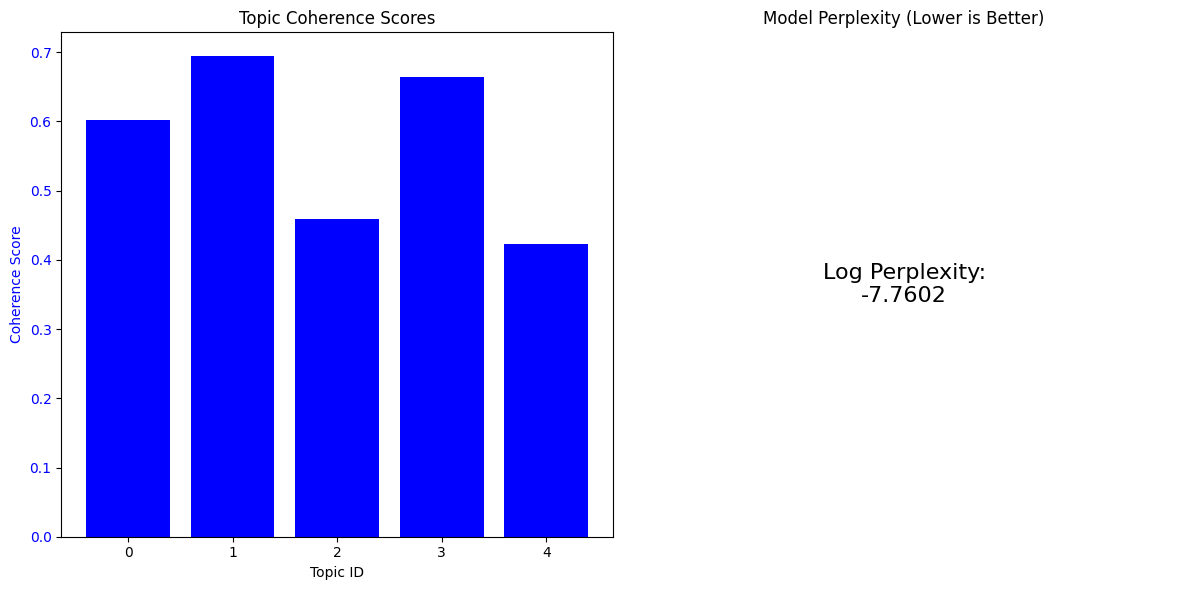


Topic Interpretation:
---------------------
Topic #1: 0.072*"driver" + 0.020*"cancel" + 0.016*"gocar" + 0.013*"susah" + 0.013*"drivernya" + 0.011*"dapet" + 0.011*"order" + 0.010*"banget" + 0.009*"titik" + 0.008*"gojek"
Interpretation: Driver Issues

Topic #2: 0.033*"driver" + 0.023*"app" + 0.012*"gojek" + 0.011*"time" + 0.011*"order" + 0.011*"good" + 0.010*"service" + 0.008*"get" + 0.007*"customer" + 0.007*"use"
Interpretation: Driver service and app usage experience

Topic #3: 0.014*"gojek" + 0.011*"promo" + 0.009*"mantap" + 0.007*"meow" + 0.007*"akun" + 0.004*"verifikasi" + 0.004*"pin" + 0.004*"email" + 0.003*"apk" + 0.003*"bagus"
Interpretation: Promo & Account Verifications

Topic #4: 0.016*"driver" + 0.013*"gojek" + 0.013*"gofood" + 0.012*"aplikasi" + 0.011*"pesanan" + 0.010*"gopay" + 0.010*"makanan" + 0.009*"1" + 0.009*"c" + 0.008*"jam"
Interpretation: GoFood Service

Topic #5: 0.031*"gojek" + 0.026*"aplikasi" + 0.013*"promo" + 0.010*"pake" + 0.010*"membantu" + 0.009*"pakai" + 0

In [ ]:
# Calculate coherence score for the LDA model
from gensim.models import CoherenceModel

# Coherence using c_v measure (most common)
coherence_model_cv = CoherenceModel(
    model=best_tuned_lda, 
    texts=reviews_tokenized, 
    dictionary=id2word, 
    coherence='c_v'
)
print(f"Coherence Score (c_v): {best_tuned_coherence:.4f}")

coherence_scores = coherence_model_cv.get_coherence_per_topic()

# You can also try other coherence measures
coherence_model_umass = CoherenceModel(
    model=best_tuned_lda, 
    texts=reviews_tokenized,
    dictionary=id2word,
    coherence='u_mass'  # UMass coherence (usually negative, higher is better)
)

coherence_score_umass = coherence_model_umass.get_coherence()
print(f"Coherence Score (UMass): {coherence_score_umass:.4f}")


print("\nModel Evaluation:")
print("----------------")
perplexity = best_tuned_lda.log_perplexity(corpus)
print(f"Perplexity: {perplexity:.4f}") 
print(f"Coherence Score (c_v): {best_tuned_coherence:.4f}")  
print(f"Coherence Score (UMass): {coherence_score_umass:.4f}")  

# Visualize both metrics together
fig, ax1 = plt.figure(figsize=(12, 6)), plt.subplot(121)
ax1.bar(range(len(coherence_scores)), coherence_scores, color='b')
ax1.set_xlabel('Topic ID')
ax1.set_ylabel('Coherence Score', color='b')
ax1.set_title('Topic Coherence Scores')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(len(coherence_scores)))

# Create a separate plot for perplexity
ax2 = plt.subplot(122)
ax2.text(0.5, 0.5, f"Log Perplexity:\n{perplexity:.4f}", 
         horizontalalignment='center', verticalalignment='center', fontsize=16)
ax2.axis('off')
ax2.set_title('Model Perplexity (Lower is Better)')

plt.tight_layout()
plt.show()

print("\nTopic Interpretation:")
print("---------------------")
for topic_id, topic in enumerate(best_tuned_lda.print_topics(num_words=10)):
    print(f"Topic #{topic_id + 1}: {topic[1]}")
    
    if topic_id == 0:
        print("Interpretation: Driver Issues")
    elif topic_id == 1:
        print("Interpretation: Driver service and app usage experience")
    elif topic_id == 2:
        print("Interpretation: Promo & Account Verifications")
    elif topic_id == 3:
        print("Interpretation: GoFood Service")
    elif topic_id == 4:
        print("Interpretation: Experience With Promo")
    print()

## 5. Categorize review tags

In [ ]:
# Ensure corpus and best_tuned_lda are defined before running this cell
if 'corpus' not in globals() or 'best_tuned_lda' not in globals():
    # Re-import and re-define if running this cell standalone
    import gensim
    import gensim.corpora as corpora
    from gensim.models.ldamodel import LdaModel
    from nltk.tokenize import word_tokenize
    reviews_tokenized = reviews['lemmatized_content'].astype(str).apply(word_tokenize)
    id2word = corpora.Dictionary(reviews_tokenized)
    corpus = [id2word.doc2bow(text) for text in reviews_tokenized]
    best_tuned_lda = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=5,
        random_state=42,
        passes=20,
        alpha="auto",
        eta="symmetric",
        per_word_topics=True
    )

# Assign each review to its most probable topic using the best LDA model
topic_assignments = [max(best_tuned_lda.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

# Count the number of reviews per topic
import pandas as pd
topic_counts = pd.Series(topic_assignments).value_counts().sort_index()

# Calculate the proportion (%) of each topic
topic_proportions = topic_counts / topic_counts.sum() * 100

# Optionally, define topic names based on your interpretation above
topic_names = {
    0: "Miscellaneous positive feedback",
    1: "Driver Service and App Experience",
    2: "Driver Issues",
    3: "Order Process and Communication",
    4: "Payment Methods and Pricing"
}

# Visualize distribution of topics
plt.figure(figsize=(12, 6))
bars = plt.bar(
    [topic_names[i] for i in topic_counts.index], 
    topic_proportions,
    color=['skyblue', 'lightgreen', 'salmon', 'plum', 'gold']  # Changed 'lightpurple' to 'plum'
)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.5,
        f"{height:.1f}%",
        ha='center', va='bottom'
    )

plt.title('Distribution of Review Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'corpus' is not defined